###Since a local GPU was used to run this notebook in order to bypass the time limits of Google Colab, the format and results will be displayed differently from all other notebooks, but with the same meaning

##🚀GPU mounting

## LOCAL SETUP WITH RTX2060
Dockerfile at https://github.com/ironoa/tensorflow-gpu-docker/blob/main/Dockerfile  
+---------------------------------------------------------------------------------------+  
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |  
|-----------------------------------------+----------------------+----------------------+

```Dockerfile
# Use the official TensorFlow image with GPU support
FROM tensorflow/tensorflow:2.17.0-gpu

# Set environment variables for Python and CUDA
ENV PYTHONUNBUFFERED=1
ENV CUDA_VISIBLE_DEVICES=0Va

# Install other Python packages
RUN apt-get update && \
    apt-get install -y python3-pip graphviz
    
RUN pip install --upgrade pip && \
    pip install numpy matplotlib scikit-learn opencv-python tensorflow-datasets seaborn

RUN pip install pydot graphviz

#important: compatibility with pipeline's environment
RUN pip install tensorflow[and-cuda]==2.17.0
RUN pip install keras==3.4.1

RUN pip install keras-cv
ENV KERAS_BACKEND=tensorflow

# Set the working directory in the container
WORKDIR /app

# Run a default command (this can be changed when running the container)
CMD ["nvidia-smi"]
```

##📚importing libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import keras_cv
from tensorflow.keras.optimizers import Lion
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer

# Set seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.keras.utils.set_random_seed(seed)

batch_size = 64
epochs = 1000
patience = 40
filename = "EfficientNetV2M_DynamicAug_Lion"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Initialize the data generator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

##📊Dataset

In previous explorations of the dataset we found some outliers and we decided to definitively remove them from out dataset

In [ ]:
# Load the dataset
data = np.load('./training_set.npz')
X = data['images']
y = data['labels']

# Drop entries from index 11958 onward if necessary
X = X[:11958]
y = y[:11958]

X shape: (11958, 96, 96, 3)
y shape: (11958, 1)


###visual inspection

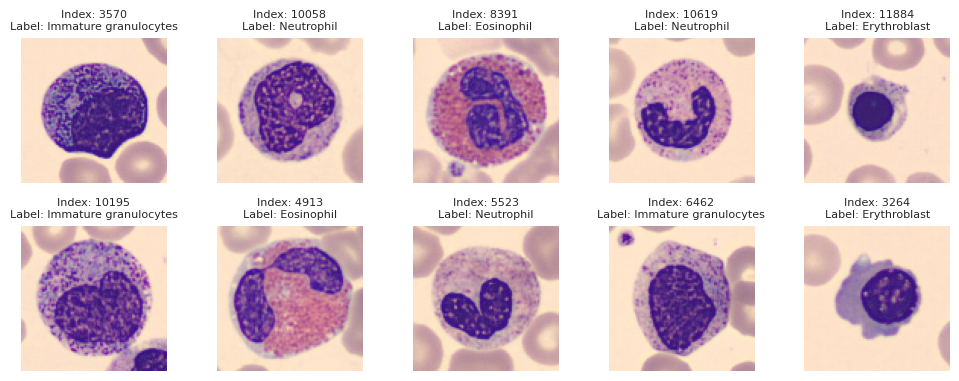

In [ ]:
# Define labels for each class
labels = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

# Number of images to display
num_images_to_display = 10

# Generate 10 random indices from the range of available data
random_indices = np.random.choice(min(len(X), len(y)), num_images_to_display, replace=False)

# Set up a 2x5 grid for displaying images
fig, axs = plt.subplots(2, 5, figsize=(10, 4))  # 2 rows, 5 columns

for idx, i in enumerate(random_indices):
    row = idx // 5  # Determine row index (0 or 1)
    col = idx % 5   # Determine column index (0 to 4)

    axs[row, col].imshow(np.squeeze(X[i]), vmin=0., vmax=1.)
    axs[row, col].set_title(f'Index: {i}\nLabel: {labels[y[i][0]]}', fontsize=8)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# get shapes for each class
for class_idx, class_name in enumerate(labels):
    # Filter y for the current class index
    y_class = y[y == class_idx]
    print(f"Numerosity of {class_name} images: {y_class.shape}")


Numerosity of Basophil images: (852,)
Numerosity of Eosinophil images: (2181,)
Numerosity of Erythroblast images: (1085,)
Numerosity of Immature granulocytes images: (2026,)
Numerosity of Lymphocyte images: (848,)
Numerosity of Monocyte images: (993,)
Numerosity of Neutrophil images: (2330,)
Numerosity of Platelet images: (1643,)


###data processing

In [ ]:
# One-hot encode labels for categorical cross-entropy loss
y = tf.keras.utils.to_categorical(y, num_classes=8)

In [ ]:
# Data splitting
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (9685, 96, 96, 3)
Training Label Shape: (9685, 8)
Validation Data Shape: (1077, 96, 96, 3)
Validation Label Shape: (1077, 8)


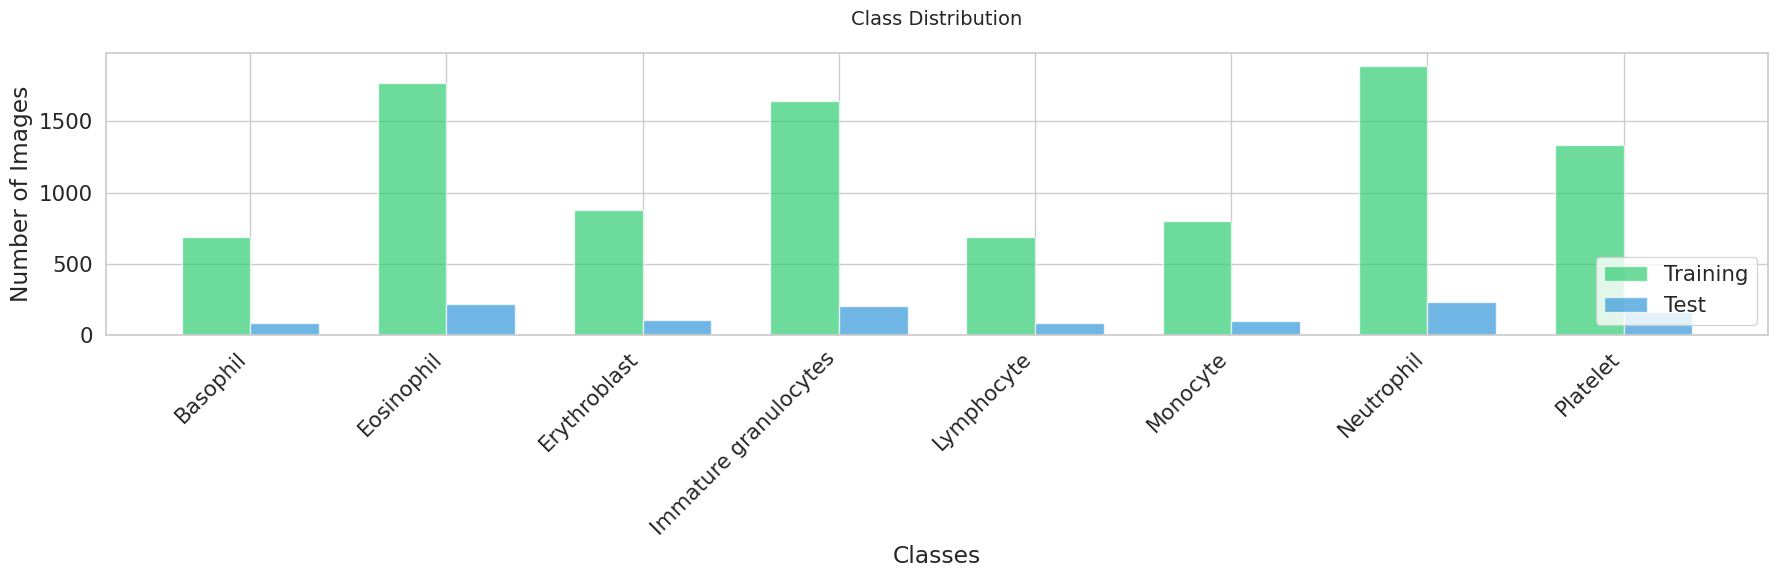

In [ ]:
def plot_class_distribution(y_train, y_test, class_names):
    # Set seaborn style for the plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(18, 6))

    # Convert one-hot encoded labels back to class indices
    y_train_indices = np.argmax(y_train, axis=1)  # Get class indices from one-hot encoded labels
    y_test_indices = np.argmax(y_test, axis=1)    # Get class indices from one-hot encoded labels


    # Calculate class distributions for training and test sets
    train_dist = np.bincount(y_train_indices) # Use class indices for bincount
    test_dist = np.bincount(y_test_indices)   # Use class indices for bincount

    # Create x positions and set bar width
    x = np.arange(len(class_names))
    width = 0.35

    # Plot bars for training and test distributions
    plt.bar(x - width / 2, train_dist, width, label='Training', color='#2ecc71', alpha=0.7)
    plt.bar(x + width / 2, test_dist, width, label='Test', color='#3498db', alpha=0.7)

    # Customise plot title and labels
    plt.title('Class Distribution', pad=20, fontsize=14)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')

    # Set class names as x-axis labels with rotation
    plt.xticks(x, class_names, rotation=45, ha='right')

    # Add legend for training and test distributions
    plt.legend(loc='lower right')

    # Adjust layout for optimal spacing
    plt.tight_layout()
    plt.show()

# Execute function to plot class distribution
plot_class_distribution(y_train, y_test, labels)

In [ ]:
#Check class numerosity
# Get shapes for each class in y_train
for class_idx, class_name in enumerate(labels):
    # Filter y_train for the current class index by checking if the one-hot column is 1
    y_class_train = y_train[np.argmax(y_train, axis=1) == class_idx]
    print(f"Numerosity of {class_name} images in training set: {y_class_train.shape[0]}")

print("\n")

Numerosity of Basophil images in training set: 690
Numerosity of Eosinophil images in training set: 1767
Numerosity of Erythroblast images in training set: 878
Numerosity of Immature granulocytes images in training set: 1641
Numerosity of Lymphocyte images in training set: 687
Numerosity of Monocyte images in training set: 804
Numerosity of Neutrophil images in training set: 1887
Numerosity of Platelet images in training set: 1331




###balancing data using synthetic data

Since the number of images is very different across classes, by applying transformations to the images of each class, we balance the class distribution to match the size of the largest class

In [ ]:
# Calculate class distribution for balancing
_, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(8), y=np.argmax(y_train, axis=1))
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Function to balance the dataset using `ImageDataGenerator`
def augment_minority_classes_with_datagen(X, y, datagen, target_count):
    augmented_images = []
    augmented_labels = []

    for class_label in range(8):  # Assuming 8 classes
        # Get indices of the current class
        indices = np.where(np.argmax(y, axis=1) == class_label)[0]
        X_class = X[indices]
        current_count = len(indices)

        # Augment the class if below target count
        num_augmentations = target_count - current_count
        if num_augmentations > 0:
            i = 0
            while i < num_augmentations:
                # Randomly select an image from the current class
                img = random.choice(X_class)
                x = img.reshape((1,) + img.shape)  # Add batch dimension

                # Generate one augmented image
                for batch in datagen.flow(x, batch_size=1):
                    augmented_images.append(batch[0])  # Add augmented image
                    augmented_labels.append(class_label)  # Add corresponding class label
                    i += 1
                    break  # Stop generating once one image is created

    # Convert augmented data to NumPy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = tf.keras.utils.to_categorical(augmented_labels, num_classes=y.shape[1])

    # Combine augmented data with original data
    X_balanced = np.concatenate((X, augmented_images), axis=0)
    y_balanced = np.concatenate((y, augmented_labels), axis=0)

    return X_balanced, y_balanced


# Verify the shapes
print(f"Training set shape before balancing: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

# Calculate max class count to balance dataset
target_count = max(counts)
print(target_count)
X_train_balanced, y_train_balanced = augment_minority_classes_with_datagen(X_train, y_train, datagen, target_count)

# Verify the shapes
print(f"Training set shape after balancing: {X_train_balanced.shape}, {y_train_balanced.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

# Verify the new class counts in `y_train_balanced`
unique_balanced, counts_balanced = np.unique(y_train_balanced.argmax(axis=1), return_counts=True)
class_counts_balanced = dict(zip(unique_balanced, counts_balanced))

# Print the final shape and counts of each class in `X_train_balanced`
print("Class counts after balancing:")
for class_label, count in class_counts_balanced.items():
    print(f"Class {class_label}: {count}")
print("\nFinal shapes:")
print(f"X_train_balanced shape: {X_train_balanced.shape}")
print(f"y_train_balanced shape: {y_train_balanced.shape}")
print("\n")

Class counts after balancing:
Class 0: 1887
Class 1: 1887
Class 2: 1887
Class 3: 1887
Class 4: 1887
Class 5: 1887
Class 6: 1887
Class 7: 1887

Final shapes:
X_train_balanced shape: (15096, 96, 96, 3)
y_train_balanced shape: (15096, 8)


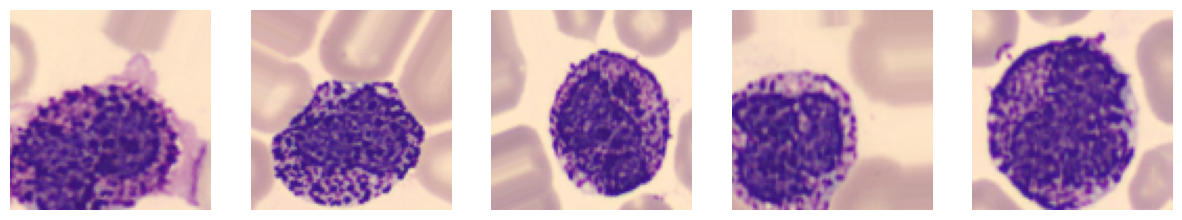

In [ ]:
# Check if the augmentation is reliable
# Display the first 5 augmented images to verify
num_images_to_display = 5
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 15))

for i in range(num_images_to_display):
    # Multiply by 255 to bring pixel values back to [0, 255] range for display
    axes[i].imshow(augmented_images[i])
    axes[i].axis('off')

plt.show()

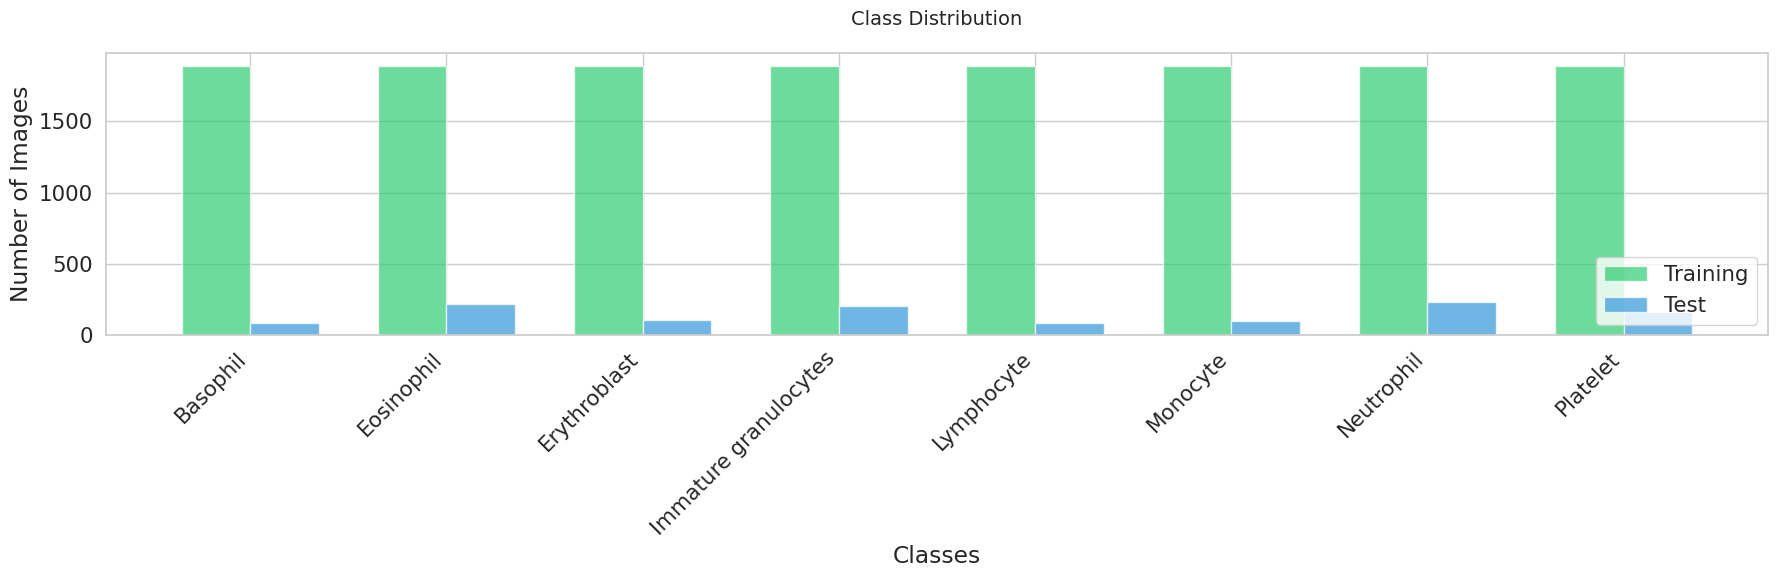

In [ ]:
# Execute function to plot new class distribution
plot_class_distribution(y_train_balanced, y_test, labels)

We can now see how each class is represented with the same number of images in the training set

In [ ]:
# Input shape for the model
input_shape = X_train_balanced.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


###preparing the dataset

Prepare the training dataset by applying RandAugment to the images, and the validation dataset (also setting the batch size)

In [ ]:
# Defines RandAugment with parameters:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),  # Adjusts the image range (0-255)
    augmentations_per_image=4,  # Number of transformations per image
    magnitude=0.3,  # Intensity of the transformations
    magnitude_stddev=0.15,  # Standard deviation for magnitude
    rate=1.0,  # Probability of applying each transformation
)

# Creation of the datasets
rand_augment_batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_ds = train_ds.batch(rand_augment_batch_size)
validation_dataset = validation_dataset.batch(rand_augment_batch_size)

# Function to apply RandAugment
def apply_rand_augment(images, labels):
    images = rand_augment(images)  # Applies RandAugment only to the images
    return images, labels

# Applies RandAugment to the training dataset
train_ds = train_ds.map(apply_rand_augment, num_parallel_calls=tf.data.AUTOTUNE)

# Preprocessing function to normalize the images
def preprocess_for_model(images, labels):
    images = tf.cast(images, tf.float32)
    labels=tf.cast(labels, tf.float32)
    return images, labels

# Preprocessing on the datasets
train_ds = train_ds.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)

# Optimizations
train_ds = train_ds.cache()  # Caches in memory
train_ds = train_ds.shuffle(buffer_size=2000)  # Shuffles the dataset
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetches the batches
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

##💡EfficientNetV2-M

###transfer learning

We apply transfer learning: we import the EfficientNetV2-M model, pre-trained on the Imagenet dataset, freezing all parameters of all layers, but excluding the final classification layer.
From this base model, we build our model by adding a Dropout layer and the final Dense classification layer.
We use Categorical Crossentropy as the loss function and Lion as the optimizer


In [ ]:
base_model = tf.keras.applications.EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(96, 96, 3),
    pooling='avg'
)                             # Import the EfficientNetV2-M model

print(f"Num of layers: {len(base_model.layers)}")

#####
# Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/efficientnet_v2/efficientnetv2-m_notop.h5
# 214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
# Num of layers: 741
#####

####step1: transfer learning

In [ ]:
base_model.trainable = False  # Freeze all layers for initial transfer learning

# Add custom layers on top of ResNet50 for our 8-class classification task
inputs = layers.Input(shape=(96, 96, 3))
x = base_model(inputs, training=False)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(8, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.summary(show_trainable=True)

####
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
# ┃ Layer (type)                          ┃ Output Shape                  ┃        Param # ┃ Traina… ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
# │ input_layer_1 (InputLayer)            │ (None, 96, 96, 3)             │              0 │    -    │
# ├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
# │ efficientnetv2-m (Functional)         │ (None, 1280)                  │     53,150,388 │    N    │
# ├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
# │ dropout (Dropout)                     │ (None, 1280)                  │              0 │    -    │
# ├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
# │ dense (Dense)                         │ (None, 8)                     │         10,248 │    Y    │
# └───────────────────────────────────────┴───────────────────────────────┴────────────────┴─────────┘
#  Total params: 53,160,636 (202.79 MB)
#  Trainable params: 10,248 (40.03 KB)
#  Non-trainable params: 53,150,388 (202.75 MB)
####

Above, you can see the structure of the created model and the number of parameters

We can train the model, also using early stopping to prevent overfitting and reduce computational time

In [ ]:
optimizer_step1 = Lion(
    learning_rate=3e-4,
    weight_decay=0.015,
)

model.compile(
    optimizer=optimizer_step1,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history_step1_obj = model.fit(
    train_ds,
    validation_data=validation_dataset,
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)]
)

# Calculate and print the best validation accuracy achieved
history_step1 = history_step1_obj.history
step1_val_accuracy = round(max(history_step1['val_accuracy']) * 100, 2)
best_epoch_step1 = history_step1['val_accuracy'].index(max(history_step1['val_accuracy'])) + 1
print(f'Validation accuracy after transfer learning: {step1_val_accuracy}%')
print(f'early stopped at epoch: {best_epoch_step1}')

# Save model
model.save(f'{filename}_{step1_val_accuracy}_STEP1.keras')

####
# Epoch 1/1000
# 2024-11-24 09:41:18.291268: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1669496832 exceeds 10% of free system memory.
# 2024-11-24 09:41:45.354674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 184 of 2000
# 2024-11-24 09:41:47.499974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
# WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
# I0000 00:00:1732441307.508201      59 service.cc:146] XLA service 0x7f39380697d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
# I0000 00:00:1732441307.508226      59 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
# 2024-11-24 09:41:48.359363: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
# 2024-11-24 09:41:50.562479: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
# 2024-11-24 09:41:56.036855: W external/local_tsl/tsl/framework/bfc_allocator.cc:363] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
# 2024-11-24 09:41:56.287494: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
# 2024-11-24 09:41:56.453189: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.82GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
# I0000 00:00:1732441329.844828      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
# 181/236 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.1756 - loss: 2.27052024-11-24 09:42:26.548215: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
# 2024-11-24 09:42:26.709345: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.1981 - loss: 2.22412024-11-24 09:42:54.933155: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
# 2024-11-24 09:42:55.090525: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.75GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 101s 209ms/step - accuracy: 0.1985 - loss: 2.2233 - val_accuracy: 0.7372 - val_loss: 1.0750
# Epoch 2/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.4709 - loss: 1.6045 - val_accuracy: 0.8078 - val_loss: 0.7127
# Epoch 3/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.5501 - loss: 1.4424 - val_accuracy: 0.8338 - val_loss: 0.5990
# Epoch 4/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.5686 - loss: 1.3642 - val_accuracy: 0.8579 - val_loss: 0.5112
# Epoch 5/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6069 - loss: 1.2416 - val_accuracy: 0.8561 - val_loss: 0.5062
# Epoch 6/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.6155 - loss: 1.2358 - val_accuracy: 0.8487 - val_loss: 0.4897
# Epoch 7/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.6061 - loss: 1.2704 - val_accuracy: 0.8589 - val_loss: 0.4758
# Epoch 8/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.6117 - loss: 1.2400 - val_accuracy: 0.8384 - val_loss: 0.5018
# Epoch 9/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6117 - loss: 1.1933 - val_accuracy: 0.8292 - val_loss: 0.5183
# Epoch 10/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6251 - loss: 1.1975 - val_accuracy: 0.8552 - val_loss: 0.4760
# Epoch 11/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.6303 - loss: 1.1687 - val_accuracy: 0.8672 - val_loss: 0.4542
# Epoch 12/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.6231 - loss: 1.1992 - val_accuracy: 0.8737 - val_loss: 0.4182
# Epoch 13/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6146 - loss: 1.1986 - val_accuracy: 0.8199 - val_loss: 0.5134
# Epoch 14/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6280 - loss: 1.1915 - val_accuracy: 0.8394 - val_loss: 0.4792
# Epoch 15/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.6221 - loss: 1.1857 - val_accuracy: 0.8347 - val_loss: 0.4851
# Epoch 16/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6211 - loss: 1.2157 - val_accuracy: 0.8422 - val_loss: 0.4824
# Epoch 17/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6254 - loss: 1.2191 - val_accuracy: 0.8617 - val_loss: 0.4403
# Epoch 18/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6282 - loss: 1.1921 - val_accuracy: 0.8579 - val_loss: 0.4350
# Epoch 19/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6240 - loss: 1.1997 - val_accuracy: 0.8552 - val_loss: 0.4525
# Epoch 20/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6141 - loss: 1.2297 - val_accuracy: 0.8579 - val_loss: 0.4461
# Epoch 21/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6284 - loss: 1.2187 - val_accuracy: 0.8672 - val_loss: 0.4292
# Epoch 22/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6399 - loss: 1.1219 - val_accuracy: 0.8496 - val_loss: 0.4521
# Epoch 23/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6292 - loss: 1.1887 - val_accuracy: 0.8765 - val_loss: 0.3955
# Epoch 24/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6325 - loss: 1.1764 - val_accuracy: 0.8737 - val_loss: 0.4024
# Epoch 25/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.6288 - loss: 1.2042 - val_accuracy: 0.8617 - val_loss: 0.4279
# Epoch 26/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6262 - loss: 1.2384 - val_accuracy: 0.8663 - val_loss: 0.4140
# Epoch 27/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6220 - loss: 1.2189 - val_accuracy: 0.8793 - val_loss: 0.3882
# Epoch 28/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6347 - loss: 1.1859 - val_accuracy: 0.8793 - val_loss: 0.4073
# Epoch 29/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.6405 - loss: 1.1652 - val_accuracy: 0.8839 - val_loss: 0.3929
# Epoch 30/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6329 - loss: 1.1658 - val_accuracy: 0.8626 - val_loss: 0.4275
# Epoch 31/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6333 - loss: 1.1546 - val_accuracy: 0.8691 - val_loss: 0.4121
# Epoch 32/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6307 - loss: 1.1786 - val_accuracy: 0.8589 - val_loss: 0.4328
# Epoch 33/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6252 - loss: 1.1536 - val_accuracy: 0.8802 - val_loss: 0.3877
# Epoch 34/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.6267 - loss: 1.1778 - val_accuracy: 0.8338 - val_loss: 0.4961
# Epoch 35/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6120 - loss: 1.2070 - val_accuracy: 0.8691 - val_loss: 0.4003
# Epoch 36/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6311 - loss: 1.1747 - val_accuracy: 0.8310 - val_loss: 0.4956
# Epoch 37/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.6253 - loss: 1.2307 - val_accuracy: 0.8459 - val_loss: 0.4480
# Epoch 38/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6240 - loss: 1.1644 - val_accuracy: 0.8542 - val_loss: 0.4401
# Epoch 39/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6270 - loss: 1.1880 - val_accuracy: 0.8449 - val_loss: 0.4701
# Epoch 40/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6392 - loss: 1.1567 - val_accuracy: 0.8719 - val_loss: 0.4101
# Epoch 41/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6286 - loss: 1.2264 - val_accuracy: 0.8598 - val_loss: 0.4378
# Epoch 42/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.6334 - loss: 1.1947 - val_accuracy: 0.8607 - val_loss: 0.4484
# Epoch 43/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6336 - loss: 1.1417 - val_accuracy: 0.8654 - val_loss: 0.4201
# Epoch 44/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.6248 - loss: 1.2098 - val_accuracy: 0.8394 - val_loss: 0.4641
# Epoch 45/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6298 - loss: 1.1832 - val_accuracy: 0.8301 - val_loss: 0.4768
# Epoch 46/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6395 - loss: 1.1485 - val_accuracy: 0.8700 - val_loss: 0.4175
# Epoch 47/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6443 - loss: 1.1652 - val_accuracy: 0.8765 - val_loss: 0.3896
# Epoch 48/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6225 - loss: 1.2226 - val_accuracy: 0.8561 - val_loss: 0.4432
# Epoch 49/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6295 - loss: 1.1669 - val_accuracy: 0.8719 - val_loss: 0.4046
# Epoch 50/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.6291 - loss: 1.1710 - val_accuracy: 0.8552 - val_loss: 0.4315
# Epoch 51/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6282 - loss: 1.2226 - val_accuracy: 0.8719 - val_loss: 0.3945
# Epoch 52/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6348 - loss: 1.1560 - val_accuracy: 0.8812 - val_loss: 0.3892
# Epoch 53/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6404 - loss: 1.1718 - val_accuracy: 0.8709 - val_loss: 0.4112
# Epoch 54/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6286 - loss: 1.2083 - val_accuracy: 0.8812 - val_loss: 0.3942
# Epoch 55/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6475 - loss: 1.1453 - val_accuracy: 0.8477 - val_loss: 0.4584
# Epoch 56/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6242 - loss: 1.1742 - val_accuracy: 0.8663 - val_loss: 0.4188
# Epoch 57/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.6258 - loss: 1.1787 - val_accuracy: 0.8617 - val_loss: 0.4240
# Epoch 58/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.6215 - loss: 1.2255 - val_accuracy: 0.8784 - val_loss: 0.3994
# Epoch 59/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6416 - loss: 1.1549 - val_accuracy: 0.8774 - val_loss: 0.3976
# Epoch 60/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6275 - loss: 1.1752 - val_accuracy: 0.8561 - val_loss: 0.4296
# Epoch 61/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6217 - loss: 1.2165 - val_accuracy: 0.8774 - val_loss: 0.3845
# Epoch 62/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6374 - loss: 1.1798 - val_accuracy: 0.8496 - val_loss: 0.4280
# Epoch 63/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6144 - loss: 1.2449 - val_accuracy: 0.8617 - val_loss: 0.4205
# Epoch 64/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6182 - loss: 1.1926 - val_accuracy: 0.8700 - val_loss: 0.4225
# Epoch 65/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6325 - loss: 1.1709 - val_accuracy: 0.8431 - val_loss: 0.4464
# Epoch 66/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6218 - loss: 1.2178 - val_accuracy: 0.8728 - val_loss: 0.4162
# Epoch 67/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6354 - loss: 1.1963 - val_accuracy: 0.8440 - val_loss: 0.4564
# Epoch 68/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6239 - loss: 1.1895 - val_accuracy: 0.8682 - val_loss: 0.4137
# Epoch 69/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6269 - loss: 1.1973 - val_accuracy: 0.8691 - val_loss: 0.4070
# Validation accuracy after transfer learning: 88.39%
# early stopped at epoch: 29
####

###fine tuning

Now let's proceed with fine-tuning: from the previously trained model, we un-freeze the last 150 layers, allowing all the parameters of these layers to be trained.
The loss function remains the same, while we continue using Lion as the optimizer, but with a smaller learning rate

####un-freezing 150 layers

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:]:
    layer.trainable = False

# Unfreeze specific layers progressively in the model
for layer in base_model.layers[-150:]:  # Adjust the number of layers as needed
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
    else:
        layer.trainable = False

model.summary(show_trainable=True)

#Reduce the learning rate and the weight decay
optimizer_step2 = Lion(
    learning_rate=1e-4,
    weight_decay=0.005,
    name="lion",
)

model.compile(
    optimizer=optimizer_step2,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

####
# Model: "functional"
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
# ┃ Layer (type)                          ┃ Output Shape                  ┃        Param # ┃ Traina… ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
# │ input_layer_1 (InputLayer)            │ (None, 96, 96, 3)             │              0 │    -    │
# ├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
# │ efficientnetv2-m (Functional)         │ (None, 1280)                  │     53,150,388 │    Y    │
# ├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
# │ dropout (Dropout)                     │ (None, 1280)                  │              0 │    -    │
# ├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
# │ dense (Dense)                         │ (None, 8)                     │         10,248 │    Y    │
# └───────────────────────────────────────┴───────────────────────────────┴────────────────┴─────────┘
#  Total params: 53,170,886 (202.83 MB)
#  Trainable params: 24,769,872 (94.49 MB)
#  Non-trainable params: 28,390,764 (108.30 MB)
#  Optimizer params: 10,250 (40.04 KB)
####

# Train
history_step2_obj = model.fit(
    train_ds,
    validation_data=validation_dataset,
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)]
)

# Retrieve accuracy values from the history
history_step2 = history_step2_obj.history
step2_val_accuracy = round(max(history_step2['val_accuracy']) * 100, 2)
best_epoch_step2 = history_step2['val_accuracy'].index(max(history_step2['val_accuracy'])) + 1
print(f'Validation accuracy after STEP2: {step2_val_accuracy}%')
print(f'early stopped at epoch: {best_epoch_step2}')

model.save(f'{filename}_{step2_val_accuracy}_STEP2.keras')

####
# Epoch 1/1000
# 2024-11-24 09:57:10.345850: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1669496832 exceeds 10% of free system memory.
# E0000 00:00:1732442258.266833      60 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
# E0000 00:00:1732442258.385748      60 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
# E0000 00:00:1732442258.897920      60 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
# E0000 00:00:1732442259.027699      60 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
# 176/236 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.5557 - loss: 1.6955E0000 00:00:1732442294.049048      59 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
# E0000 00:00:1732442294.167225      59 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
# E0000 00:00:1732442294.663770      59 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
# E0000 00:00:1732442294.791714      59 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 97s 228ms/step - accuracy: 0.5797 - loss: 1.5736 - val_accuracy: 0.8979 - val_loss: 0.2771
# Epoch 2/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.7763 - loss: 0.7578 - val_accuracy: 0.9090 - val_loss: 0.2695
# Epoch 3/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.7939 - loss: 0.9075 - val_accuracy: 0.8366 - val_loss: 0.5026
# Epoch 4/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.3448 - loss: 551773.5000 - val_accuracy: 0.0706 - val_loss: 960.4841
# Epoch 5/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1221 - loss: 116291872.0000 - val_accuracy: 0.1504 - val_loss: 22394.7695
# Epoch 6/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1230 - loss: 8608423.0000 - val_accuracy: 0.0715 - val_loss: 1168376.1250
# Epoch 7/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1248 - loss: 313933984.0000 - val_accuracy: 0.0891 - val_loss: 506034.8750
# Epoch 8/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1326 - loss: 4894429184.0000 - val_accuracy: 0.1820 - val_loss: 83507776.0000
# Epoch 9/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1246 - loss: 131577110528.0000 - val_accuracy: 0.0715 - val_loss: 107595186176.0000
# Epoch 10/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1227 - loss: 3563216961536.0000 - val_accuracy: 0.0706 - val_loss: 1926535577600.0000
# Epoch 11/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1261 - loss: 1794235564032.0000 - val_accuracy: 0.0836 - val_loss: 42857902080.0000
# Epoch 12/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1188 - loss: 80042622976.0000 - val_accuracy: 0.0715 - val_loss: 2.1429
# Epoch 13/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1320 - loss: 7019041176682496.0000 - val_accuracy: 0.0715 - val_loss: 6456711577600.0000
# Epoch 14/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1189 - loss: 984093709828096.0000 - val_accuracy: 0.0715 - val_loss: 2.1622
# Epoch 15/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1341 - loss: 331192578605056.0000 - val_accuracy: 0.0715 - val_loss: 2.1709
# Epoch 16/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1247 - loss: 181924455197442048.0000 - val_accuracy: 0.0715 - val_loss: 2.1807
# Epoch 17/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1261 - loss: 28661475376585768960.0000 - val_accuracy: 0.0715 - val_loss: 2.1903
# Epoch 18/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1306 - loss: 2369108792311808.0000 - val_accuracy: 0.0715 - val_loss: 2.1982
# Epoch 19/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1304 - loss: 1353127030685696.0000 - val_accuracy: 0.0715 - val_loss: 2.2082
# Epoch 20/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1164 - loss: 3107495543308288.0000 - val_accuracy: 0.0715 - val_loss: 2.2170
# Epoch 21/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1358 - loss: 2515670524755968.0000 - val_accuracy: 0.0715 - val_loss: 2.2267
# Epoch 22/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1457 - loss: 291343570042880.0000 - val_accuracy: 0.0715 - val_loss: 2.2350
# Epoch 23/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1167 - loss: 358044881911808.0000 - val_accuracy: 0.0715 - val_loss: 2.2435
# Epoch 24/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1159 - loss: 10433299742720.0000 - val_accuracy: 0.0715 - val_loss: 2.2498
# Epoch 25/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1173 - loss: 39208261517312.0000 - val_accuracy: 0.0715 - val_loss: 2.2575
# Epoch 26/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1314 - loss: 80290367670807691264.0000 - val_accuracy: 0.0715 - val_loss: 2.2628
# Epoch 27/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1458 - loss: 11436472401920.0000 - val_accuracy: 0.0715 - val_loss: 2.2686
# Epoch 28/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1402 - loss: 24489521840128.0000 - val_accuracy: 0.0715 - val_loss: 2.2716
# Epoch 29/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1073 - loss: 916865154216361984.0000 - val_accuracy: 0.0715 - val_loss: 2.2746
# Epoch 30/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1416 - loss: 17084774313099264.0000 - val_accuracy: 0.0715 - val_loss: 2.2802
# Epoch 31/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1234 - loss: 81364995151423864832.0000 - val_accuracy: 0.0715 - val_loss: 2.2819
# Epoch 32/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1274 - loss: 257178707631875817472.0000 - val_accuracy: 0.0715 - val_loss: 2.2833
# Epoch 33/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1047 - loss: 197949740277815050240.0000 - val_accuracy: 0.0706 - val_loss: 2.2853
# Epoch 34/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1010 - loss: 415449231604580352.0000 - val_accuracy: 0.0715 - val_loss: 2.2896
# Epoch 35/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.0866 - loss: 1855798606313816064.0000 - val_accuracy: 0.0715 - val_loss: 2.2898
# Epoch 36/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1346 - loss: nan - val_accuracy: 0.1374 - val_loss: nan
# Epoch 37/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1073 - loss: nan - val_accuracy: 0.1374 - val_loss: nan
# Epoch 38/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1221 - loss: nan - val_accuracy: 0.1374 - val_loss: nan
# Epoch 39/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1275 - loss: nan - val_accuracy: 0.1374 - val_loss: nan
# Epoch 40/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1109 - loss: nan - val_accuracy: 0.1374 - val_loss: nan
# Epoch 41/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1300 - loss: nan - val_accuracy: 0.1374 - val_loss: nan
# Epoch 42/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.1138 - loss: nan - val_accuracy: 0.1374 - val_loss: nan
# Validation accuracy after STEP2: 90.9%
# early stopped at epoch: 2
####

Above, we can see which layers are frozen and which are now trainable, along with the number of trainable and non-trainable parameters.
Then the training of this new configuration of the model is shown.  
      
In the output, a non-convergence issue was observed, leading to a rapid degradation of the metrics. This issue was likely caused by an excessively high learning rate. While we retrained the model with a corrected learning rate, we were unable to replicate the peak performance achieved by this run on the hidden dataset (85% vs 83%), despite the observed issue.

Now let's proceed with a second fine-tuning: from the previously trained model, we un-freeze now the last 400 layers, allowing all the parameters from these layers to be trained.
The loss function remains the same, while we continue using Lion as the optimizer, but with an even smaller learning rate then the one used in previous fine-tuning stage

####un-freezing 400 layers

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:]:
    layer.trainable = False

# Unfreeze specific layers progressively in the model
for layer in base_model.layers[-400:]:  # Adjust the number of layers as needed
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
    else:
        layer.trainable = False

model.summary(show_trainable=True)

####
# Model: "functional"
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
# ┃ Layer (type)                          ┃ Output Shape                  ┃        Param # ┃ Traina… ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
# │ input_layer_1 (InputLayer)            │ (None, 96, 96, 3)             │              0 │    -    │
# ├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
# │ efficientnetv2-m (Functional)         │ (None, 1280)                  │     53,150,388 │    Y    │
# ├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
# │ dropout (Dropout)                     │ (None, 1280)                  │              0 │    -    │
# ├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
# │ dense (Dense)                         │ (None, 8)                     │         10,248 │    Y    │
# └───────────────────────────────────────┴───────────────────────────────┴────────────────┴─────────┘
#  Total params: 77,930,510 (297.28 MB)
#  Trainable params: 44,495,068 (169.74 MB)
#  Non-trainable params: 8,665,568 (33.06 MB)
#  Optimizer params: 24,769,874 (94.49 MB)
####

# Reduce learning rate and weight decay even further
optimizer_step3 = Lion(
    learning_rate=3e-6,
    weight_decay=0.0002,
    name="lion",
)

model.compile(
    optimizer=optimizer_step3,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Train
history_step3_obj = model.fit(
    train_ds,
    validation_data=validation_dataset,
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)]
)

# Retrieve accuracy values from the history
history_step3 = history_step3_obj.history
step3_val_accuracy = round(max(history_step3['val_accuracy']) * 100, 2)
best_epoch_step3 = history_step3['val_accuracy'].index(max(history_step3['val_accuracy'])) + 1
print(f'Validation accuracy after STEP3: {step3_val_accuracy}%')
print(f'early stopped at epoch: {best_epoch_step3}')

# Save model
model.save(f'{filename}_{step3_val_accuracy}_final.keras')

####
# Epoch 1/1000
# 2024-11-24 10:10:55.548714: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1669496832 exceeds 10% of free system memory.
# E0000 00:00:1732443088.266177      61 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
# E0000 00:00:1732443088.388074      61 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
#  42/236 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.7978 - loss: 0.6623E0000 00:00:1732443117.549261      61 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
# E0000 00:00:1732443117.668929      61 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 111s 262ms/step - accuracy: 0.8322 - loss: 0.5977 - val_accuracy: 0.9341 - val_loss: 0.1790
# Epoch 2/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.8644 - loss: 0.4363 - val_accuracy: 0.9424 - val_loss: 0.1650
# Epoch 3/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.8933 - loss: 0.3343 - val_accuracy: 0.9378 - val_loss: 0.1905
# Epoch 4/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9152 - loss: 0.2445 - val_accuracy: 0.9387 - val_loss: 0.1942
# Epoch 5/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9419 - loss: 0.1811 - val_accuracy: 0.9461 - val_loss: 0.1617
# Epoch 6/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9558 - loss: 0.1346 - val_accuracy: 0.9499 - val_loss: 0.1554
# Epoch 7/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9623 - loss: 0.1087 - val_accuracy: 0.9610 - val_loss: 0.1262
# Epoch 8/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9750 - loss: 0.0838 - val_accuracy: 0.9526 - val_loss: 0.1726
# Epoch 9/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.9815 - loss: 0.0610 - val_accuracy: 0.9554 - val_loss: 0.1892
# Epoch 10/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9820 - loss: 0.0560 - val_accuracy: 0.9508 - val_loss: 0.1919
# Epoch 11/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9839 - loss: 0.0454 - val_accuracy: 0.9545 - val_loss: 0.1746
# Epoch 12/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9849 - loss: 0.0406 - val_accuracy: 0.9601 - val_loss: 0.1764
# Epoch 13/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9882 - loss: 0.0359 - val_accuracy: 0.9591 - val_loss: 0.1503
# Epoch 14/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9913 - loss: 0.0309 - val_accuracy: 0.9647 - val_loss: 0.1362
# Epoch 15/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9898 - loss: 0.0331 - val_accuracy: 0.9573 - val_loss: 0.1414
# Epoch 16/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9911 - loss: 0.0291 - val_accuracy: 0.9424 - val_loss: 0.2571
# Epoch 17/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9917 - loss: 0.0284 - val_accuracy: 0.9536 - val_loss: 0.2003
# Epoch 18/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - accuracy: 0.9923 - loss: 0.0253 - val_accuracy: 0.9508 - val_loss: 0.2416
# Epoch 19/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9917 - loss: 0.0276 - val_accuracy: 0.9582 - val_loss: 0.2248
# Epoch 20/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9942 - loss: 0.0225 - val_accuracy: 0.9536 - val_loss: 0.1862
# Epoch 21/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9941 - loss: 0.0193 - val_accuracy: 0.9526 - val_loss: 0.2246
# Epoch 22/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9940 - loss: 0.0203 - val_accuracy: 0.9564 - val_loss: 0.2139
# Epoch 23/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9944 - loss: 0.0197 - val_accuracy: 0.9619 - val_loss: 0.1586
# Epoch 24/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9949 - loss: 0.0152 - val_accuracy: 0.9647 - val_loss: 0.1582
# Epoch 25/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9944 - loss: 0.0163 - val_accuracy: 0.9582 - val_loss: 0.1838
# Epoch 26/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9948 - loss: 0.0151 - val_accuracy: 0.9554 - val_loss: 0.2473
# Epoch 27/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9948 - loss: 0.0202 - val_accuracy: 0.9647 - val_loss: 0.1745
# Epoch 28/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9953 - loss: 0.0136 - val_accuracy: 0.9647 - val_loss: 0.1621
# Epoch 29/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9952 - loss: 0.0158 - val_accuracy: 0.9619 - val_loss: 0.1800
# Epoch 30/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9950 - loss: 0.0160 - val_accuracy: 0.9629 - val_loss: 0.1894
# Epoch 31/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.9970 - loss: 0.0141 - val_accuracy: 0.9675 - val_loss: 0.1546
# Epoch 32/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.9967 - loss: 0.0099 - val_accuracy: 0.9517 - val_loss: 0.2438
# Epoch 33/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9953 - loss: 0.0134 - val_accuracy: 0.9536 - val_loss: 0.2260
# Epoch 34/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9966 - loss: 0.0123 - val_accuracy: 0.9564 - val_loss: 0.2120
# Epoch 35/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9961 - loss: 0.0139 - val_accuracy: 0.9610 - val_loss: 0.1694
# Epoch 36/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9964 - loss: 0.0110 - val_accuracy: 0.9638 - val_loss: 0.1705
# Epoch 37/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9946 - loss: 0.0178 - val_accuracy: 0.9591 - val_loss: 0.1946
# Epoch 38/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9963 - loss: 0.0126 - val_accuracy: 0.9582 - val_loss: 0.2308
# Epoch 39/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9960 - loss: 0.0140 - val_accuracy: 0.9564 - val_loss: 0.1904
# Epoch 40/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9963 - loss: 0.0115 - val_accuracy: 0.9554 - val_loss: 0.1941
# Epoch 41/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.9966 - loss: 0.0118 - val_accuracy: 0.9582 - val_loss: 0.1768
# Epoch 42/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - accuracy: 0.9953 - loss: 0.0175 - val_accuracy: 0.9591 - val_loss: 0.1995
# Epoch 43/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9965 - loss: 0.0103 - val_accuracy: 0.9675 - val_loss: 0.1676
# Epoch 44/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9972 - loss: 0.0110 - val_accuracy: 0.9601 - val_loss: 0.1917
# Epoch 45/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9973 - loss: 0.0090 - val_accuracy: 0.9629 - val_loss: 0.2134
# Epoch 46/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9972 - loss: 0.0107 - val_accuracy: 0.9638 - val_loss: 0.1993
# Epoch 47/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9983 - loss: 0.0060 - val_accuracy: 0.9610 - val_loss: 0.1851
# Epoch 48/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9978 - loss: 0.0090 - val_accuracy: 0.9554 - val_loss: 0.2966
# Epoch 49/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9958 - loss: 0.0106 - val_accuracy: 0.9536 - val_loss: 0.2740
# Epoch 50/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - accuracy: 0.9972 - loss: 0.0101 - val_accuracy: 0.9471 - val_loss: 0.2829
# Epoch 51/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9958 - loss: 0.0129 - val_accuracy: 0.9601 - val_loss: 0.1944
# Epoch 52/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9967 - loss: 0.0082 - val_accuracy: 0.9582 - val_loss: 0.2322
# Epoch 53/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9978 - loss: 0.0086 - val_accuracy: 0.9610 - val_loss: 0.2049
# Epoch 54/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9973 - loss: 0.0119 - val_accuracy: 0.9452 - val_loss: 0.2275
# Epoch 55/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9964 - loss: 0.0101 - val_accuracy: 0.9629 - val_loss: 0.1743
# Epoch 56/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9993 - loss: 0.0043 - val_accuracy: 0.9526 - val_loss: 0.2607
# Epoch 57/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9975 - loss: 0.0126 - val_accuracy: 0.9536 - val_loss: 0.2697
# Epoch 58/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9975 - loss: 0.0073 - val_accuracy: 0.9638 - val_loss: 0.1828
# Epoch 59/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9963 - loss: 0.0122 - val_accuracy: 0.9610 - val_loss: 0.2269
# Epoch 60/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9983 - loss: 0.0071 - val_accuracy: 0.9638 - val_loss: 0.1999
# Epoch 61/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9974 - loss: 0.0130 - val_accuracy: 0.9554 - val_loss: 0.2420
# Epoch 62/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9970 - loss: 0.0113 - val_accuracy: 0.9610 - val_loss: 0.2065
# Epoch 63/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9954 - loss: 0.0142 - val_accuracy: 0.9526 - val_loss: 0.2044
# Epoch 64/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9982 - loss: 0.0070 - val_accuracy: 0.9610 - val_loss: 0.2300
# Epoch 65/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9979 - loss: 0.0099 - val_accuracy: 0.9629 - val_loss: 0.1866
# Epoch 66/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9978 - loss: 0.0065 - val_accuracy: 0.9684 - val_loss: 0.1772
# Epoch 67/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9979 - loss: 0.0089 - val_accuracy: 0.9591 - val_loss: 0.2001
# Epoch 68/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9979 - loss: 0.0064 - val_accuracy: 0.9638 - val_loss: 0.2097
# Epoch 69/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9987 - loss: 0.0050 - val_accuracy: 0.9554 - val_loss: 0.2371
# Epoch 70/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9984 - loss: 0.0058 - val_accuracy: 0.9489 - val_loss: 0.2838
# Epoch 71/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9984 - loss: 0.0063 - val_accuracy: 0.9638 - val_loss: 0.2072
# Epoch 72/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9974 - loss: 0.0078 - val_accuracy: 0.9517 - val_loss: 0.2866
# Epoch 73/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9972 - loss: 0.0110 - val_accuracy: 0.9564 - val_loss: 0.2209
# Epoch 74/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9980 - loss: 0.0075 - val_accuracy: 0.9647 - val_loss: 0.1806
# Epoch 75/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9984 - loss: 0.0049 - val_accuracy: 0.9536 - val_loss: 0.2557
# Epoch 76/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9984 - loss: 0.0048 - val_accuracy: 0.9545 - val_loss: 0.2088
# Epoch 77/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9980 - loss: 0.0073 - val_accuracy: 0.9591 - val_loss: 0.2349
# Epoch 78/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9983 - loss: 289.3104 - val_accuracy: 0.9629 - val_loss: 0.1660
# Epoch 79/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9978 - loss: 0.0062 - val_accuracy: 0.9554 - val_loss: 0.1738
# Epoch 80/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9917 - loss: 0.0243 - val_accuracy: 0.9582 - val_loss: 0.1780
# Epoch 81/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9719 - loss: 0.0870 - val_accuracy: 0.9554 - val_loss: 0.1755
# Epoch 82/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - accuracy: 0.9531 - loss: 0.1440 - val_accuracy: 0.9564 - val_loss: 0.1674
# Epoch 83/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9520 - loss: 0.1591 - val_accuracy: 0.9582 - val_loss: 0.1511
# Epoch 84/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9706 - loss: 0.0896 - val_accuracy: 0.9582 - val_loss: 0.1739
# Epoch 85/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9825 - loss: 0.0515 - val_accuracy: 0.9610 - val_loss: 0.1810
# Epoch 86/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9902 - loss: 0.2374 - val_accuracy: 0.9610 - val_loss: 0.1677
# Epoch 87/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9908 - loss: 154576.2969 - val_accuracy: 0.9554 - val_loss: 0.1861
# Epoch 88/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9746 - loss: 0.0809 - val_accuracy: 0.9415 - val_loss: 0.1973
# Epoch 89/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9328 - loss: 5.7595 - val_accuracy: 0.9369 - val_loss: 0.2078
# Epoch 90/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.8771 - loss: 0.6769 - val_accuracy: 0.9313 - val_loss: 0.1998
# Epoch 91/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.8478 - loss: 0.4767 - val_accuracy: 0.9359 - val_loss: 0.1980
# Epoch 92/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.8418 - loss: 0.4893 - val_accuracy: 0.9387 - val_loss: 0.1850
# Epoch 93/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.8847 - loss: 0.3720 - val_accuracy: 0.9536 - val_loss: 0.1372
# Epoch 94/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9219 - loss: 0.2462 - val_accuracy: 0.9471 - val_loss: 0.1499
# Epoch 95/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9464 - loss: 0.1598 - val_accuracy: 0.9582 - val_loss: 0.1271
# Epoch 96/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9683 - loss: 0.0997 - val_accuracy: 0.9638 - val_loss: 0.1056
# Epoch 97/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9774 - loss: 0.0646 - val_accuracy: 0.9610 - val_loss: 0.1286
# Epoch 98/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - accuracy: 0.9802 - loss: 0.0537 - val_accuracy: 0.9629 - val_loss: 0.1437
# Epoch 99/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.9860 - loss: 0.0427 - val_accuracy: 0.9601 - val_loss: 0.1725
# Epoch 100/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9885 - loss: 0.0378 - val_accuracy: 0.9666 - val_loss: 0.1603
# Epoch 101/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9905 - loss: 0.0348 - val_accuracy: 0.9489 - val_loss: 0.2011
# Epoch 102/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.9882 - loss: 0.0333 - val_accuracy: 0.9582 - val_loss: 0.1699
# Epoch 103/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9916 - loss: 0.0253 - val_accuracy: 0.9647 - val_loss: 0.1447
# Epoch 104/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9944 - loss: 0.0167 - val_accuracy: 0.9675 - val_loss: 0.1495
# Epoch 105/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9939 - loss: 0.0223 - val_accuracy: 0.9666 - val_loss: 0.1222
# Epoch 106/1000
# 236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9946 - loss: 0.0185 - val_accuracy: 0.9536 - val_loss: 0.2098
# Validation accuracy after STEP3: 96.84%
# early stopped at epoch: 66
####

Above, we can see which layers are frozen and which are now trainable, along with the number of trainable and non-trainable parameters.
Then the training of this new configuration of the model is shown

Here a recap of the three stages is shown

In [ ]:
print("*******RECAP***********")
print(f'Validation accuracy after transfer learning (STEP1): {step1_val_accuracy}%')
print(f'STEP1 early stopped at: {best_epoch_step1}')
print(f'Validation accuracy after STEP2: {step2_val_accuracy}%')
print(f'STEP2 early stopped at: {best_epoch_step2}')
print(f'Validation validation accuracy after STEP3: {step3_val_accuracy}%')
print(f'STEP3 early stopped at: {best_epoch_step3}')
print(f'Test accuracy: {test_accuracy:.4f}')

####
# *******RECAP***********
# Validation accuracy after transfer learning (STEP1): 88.39%
# STEP1 early stopped at: 29
# Validation accuracy after STEP2: 90.9%
# STEP2 early stopped at: 2
# Validation validation accuracy after STEP3: 96.84%
# STEP3 early stopped at: 66
# Test accuracy: 0.9649
####

#####make inference

We can now use the trained model to see how it performs on a test dataset, never seen by the model before

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

####
# Test accuracy: 0.9649
####

In [ ]:
# Initialize the model
from model import Model
import numpy as np
from tensorflow import keras as tfk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from keras.config import enable_unsafe_deserialization

# Define a mapping of labels to their corresponding digit names
labels = {0: 'Basophil', 1: 'Eosinophil', 2: 'Erythroblast', 3: 'Immature granulocytes',
          4: 'Lymphocyte', 5: 'Monocyte', 6: 'Neutrophil', 7: 'Platelet'}

model = Model()

seed=42

data = np.load('./training_set.npz')
X = data['images']
y = data['labels']

# Drop entries from index 1958 onward
X = X[:11958]
y = y[:11958]

# One-hot encode labels for categorical cross-entropy loss
y = tfk.utils.to_categorical(y, num_classes=8)

# We just want the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

# Predict class labels on test data
predictions = model.predict(X_test)

# Display the shape and type of predictions for debugging
print("Predictions Shape:", predictions.shape)
print("Predictions Type:", type(predictions))

####
# 38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step
# Predictions Shape: (1196,)
# Predictions Type: <class 'numpy.ndarray'>
####

# Ensure predictions are in the correct format
if predictions.ndim == 2 and predictions.shape[1] > 1:
    # If predictions are probabilities, get the class indices
    pred_classes = np.argmax(predictions, axis=-1)
elif predictions.ndim == 1:
    # If already class indices, use as-is
    pred_classes = predictions
else:
    # Handle case where predictions output is not in expected shape
    pred_classes = predictions.flatten()

# Convert predictions to integer type to match y_test
pred_classes = np.array(pred_classes).astype(int)

# Extract ground truth classes from one-hot encoded y_test
true_classes = np.argmax(y_test, axis=-1)

# Ensure both arrays are 1D and have the same length
print("True Classes Shape:", true_classes.shape)
print("Pred Classes Shape:", pred_classes.shape)

####
# True Classes Shape: (1196,)
# Pred Classes Shape: (1196,)
####

# Check if shapes match, if not, raise an error
if true_classes.shape != pred_classes.shape:
    raise ValueError(f"Shape mismatch between true classes and predictions: {true_classes.shape} vs {pred_classes.shape}")

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_classes, pred_classes)
precision = precision_score(true_classes, pred_classes, average='weighted')
recall = recall_score(true_classes, pred_classes, average='weighted')
f1 = f1_score(true_classes, pred_classes, average='weighted')

print(f'Accuracy: {round(accuracy, 4)}')
print(f'Precision: {round(precision, 4)}')
print(f'Recall: {round(recall, 4)}')
print(f'F1 Score: {round(f1, 4)}')

####
# Accuracy: 0.9758
# Precision: 0.9758
# Recall: 0.9758
# F1 Score: 0.9757
####

# Confusion Matrix Plot
cm = confusion_matrix(true_classes, pred_classes)
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.savefig("confusion_matrix.png")

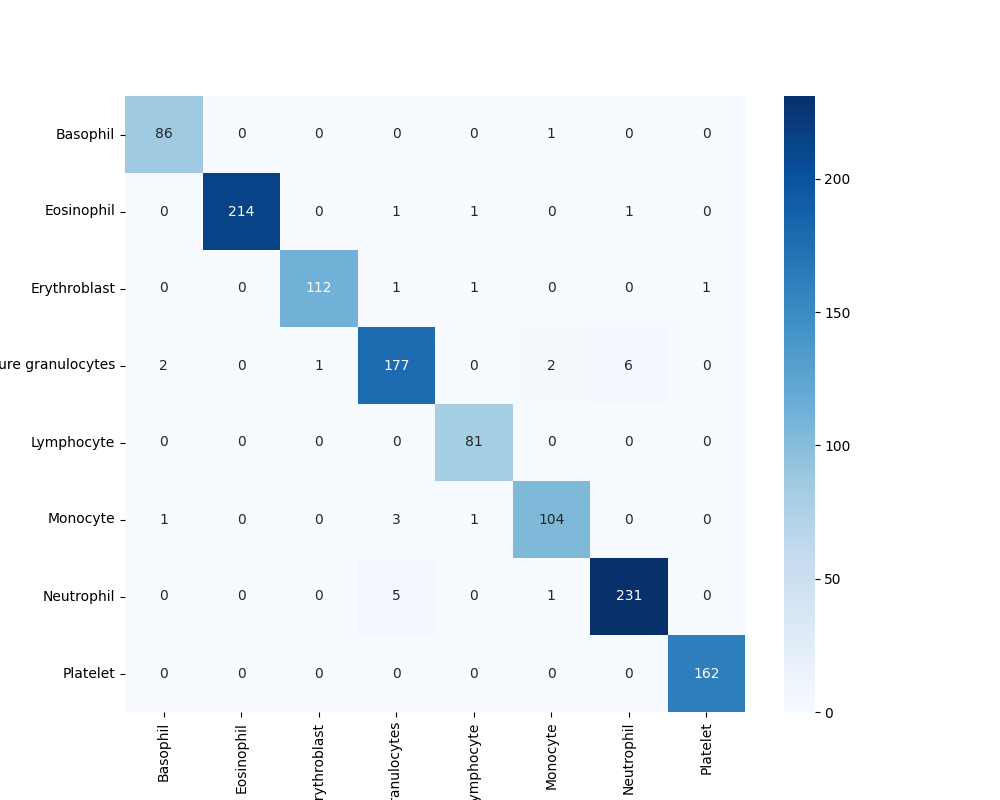


Above, we can see the results from the predictions made on the test dataset: the confusion matrix is shown and accuracy, precision, recall and F1 score are calculated

##🗂️preparing the submission

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk

class Model:
    def __init__(self):
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Parameters:
            X (numpy array): A numpy array of shape (n_samples, 96, 96, 3).

        Returns:
            numpy array: A numpy array of shape (n_samples,), with predicted class labels
                         (not one-hot encoded).
        """
        preds = self.neural_network.predict(X)

        # Convert one-hot or probability predictions to class labels
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)

        return preds